##### CONVERTING THE IMAGE LABELS FROM YOLO LABEL TO CSV FILE TO EXTRACT THE IMAGE

In [1]:

import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

ModuleNotFoundError: No module named 'cv2'

In [ ]:
path = '/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'

In [ ]:
data = [os.path.join(path,x) for x in os.listdir(path)]

In [ ]:
images = [data[x] for x in range(len(data)) if data[x].endswith('.jpeg')]

In [ ]:
labels = [data[x] for x in range(len(data)) if data[x].endswith('.txt')]

In [ ]:
#checking our conversion is working or not
plt.imshow(cv2.cvtColor(cv2.imread(images[0]),cv2.COLOR_BGR2RGB))

In [ ]:
df = pd.DataFrame(columns=['image_name','object','x_cen','y_cen','w','h'])
i=0
for id in tqdm(images):
    label = open(id[:-5]+'.txt','r') 
    a = label.read()
    label.close()
    label = a.split('\n')
    cleaned_label = label[:-1]
    
    for name in cleaned_label:
        ind_label = name.split(' ')
        df.loc[i,'image_name'] = id[78:]
        df.loc[i,'object'] = int(ind_label[0])
        df.loc[i,'x_cen'] = float(ind_label[1])
        df.loc[i,'y_cen'] = float(ind_label[2])
        df.loc[i,'w'] = float(ind_label[3])
        df.loc[i,'h'] = float(ind_label[4])
        i += 1
    

In [ ]:
df.head()

In [ ]:
#column name for pascal-voc dataframe
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

In [ ]:
pascal_voc = pd.DataFrame(columns=column_name)
for i in tqdm(range(len(df))):
    
    pascal_voc.loc[i,'filename'] = df.loc[i,'image_name']
    pascal_voc.loc[i,'width'] = 512
    pascal_voc.loc[i,'height']= 512  
    if df.loc[i,'object'] == 0:    
        pascal_voc.loc[i,'class'] = 'crop'
    else:
        pascal_voc.loc[i,'class'] = 'weed'
    pascal_voc.loc[i,'xmin']  = int((df.loc[i,'x_cen'] - df.loc[i,'w']/2)*512)
    pascal_voc.loc[i,'ymin']  = int((df.loc[i,'y_cen'] - df.loc[i,'h']/2)*512)
    pascal_voc.loc[i,'xmax']  = int((df.loc[i,'x_cen'] + df.loc[i,'w']/2)*512)
    pascal_voc.loc[i,'ymax']  = int((df.loc[i,'y_cen'] + df.loc[i,'h']/2)*512) 

In [ ]:
pascal_voc

In [ ]:
any_index_number = 55 #change this number for different images
test_img = cv2.cvtColor(cv2.imread(path+pascal_voc.loc[any_index_number,'filename']),cv2.COLOR_BGR2RGB)
test_df = pascal_voc[pascal_voc['filename']==pascal_voc.loc[any_index_number,'filename']].reset_index(drop=True)
for i in range(len(test_df)):
    
    rec = cv2.rectangle(test_img, (test_df.loc[i,'xmin'],test_df.loc[i,'ymin']), (test_df.loc[i,'xmax'],test_df.loc[i,'ymax']), (255,0,0), 1, 1) 
    text = cv2.putText(rec, test_df.loc[i,'class'], (test_df.loc[i,'xmin'],test_df.loc[i,'ymin']-10), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2, cv2.LINE_AA)
    
plt.figure(figsize=(8,8))    
plt.imshow(text)
plt.axis('off')
plt.show()

In [ ]:
pascal_voc.to_csv('pascal_voc_format.csv',index=False)

###### Using the csv file generated train the model

In [ ]:

df = pd.read_csv(r"/kaggle/input/agri-label/agri_label.csv")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
_ , axes = plt.subplots(4,4,figsize=(16,16))
for i,ax in tqdm(zip(range(16),axes.flat)):
    temp_df = df[df['filename']==folder_images[i]].reset_index(drop=True)
    temp_img = cv2.imread(path+folder_images[i])
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    for j in range(len(temp_df)):
        rect = cv2.rectangle(temp_img,(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']),(temp_df.loc[j,'xmax'],temp_df.loc[j,'ymax']),(255,0,0),2,cv2.LINE_AA)
        rect_text = cv2.putText(rect,temp_df.loc[j,'class'],(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']-8), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2, cv2.LINE_AA)
    ax.imshow(rect_text)
    plt.axis('off')

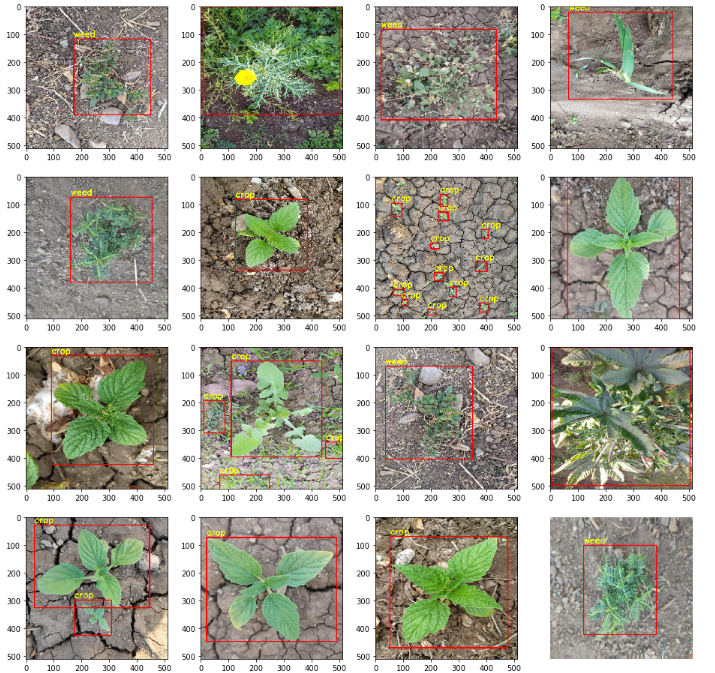

In [ ]:
import keras
keras.__version__
from keras import layers
from keras import models
from keras import optimizers

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150,150,3))) #(3 canales iniciales*32 nodos*3pix*3pix)+32 bias= 896 param
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #(32 nodos posteriores*64 nodos*3pix*3pix)+64 bias= 18496 param
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) #(64 nodos posteriores*128 nodos*3pix*3pix)+128 bias= 73856 param
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) #(128 nodos posteriores*128 nodos*3pix*3pix)+128 bias= 147584 param
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) #7*7*128 del max pooling anterior
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu')) #(6272 de la capa anterior *512 capa densa)+512 bias = 3211776
model.add(layers.Dense(4, activation='softmax')) #(512 capa anterior*4 capa densa)+4 bias = 2052
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
  
        train_dir,

        target_size=(150, 150),
        color_mode="rgb",
     
        batch_size=92,
       
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=31,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode="rgb",
        batch_size=31,
        class_mode='categorical')

In [ ]:
import math
training_samples =1300
batch_size_training_generator=32
validation_samples =3067
batch_size_validation_generator=31

history = model.fit_generator(
      train_generator,steps_per_epoch=math.ceil(training_samples/batch_size_training_generator),
      epochs=15,
      validation_data=validation_generator,
      validation_steps=math.ceil(validation_samples/batch_size_validation_generator))

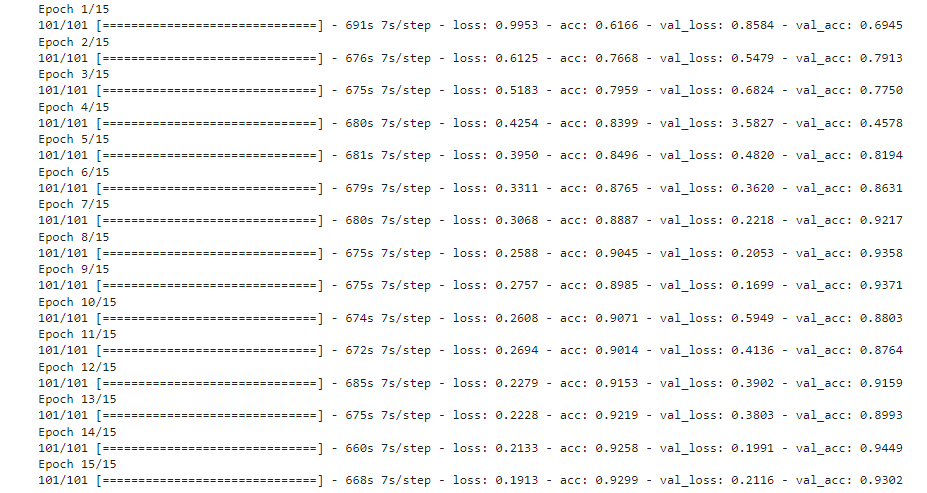

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

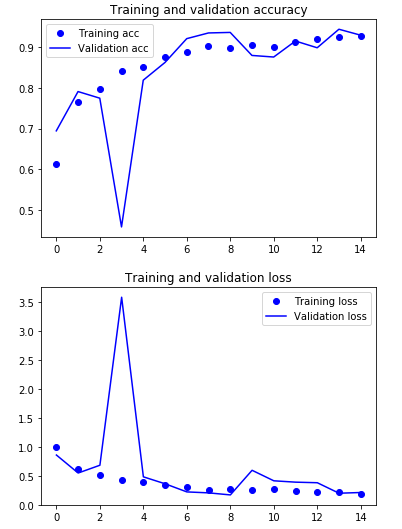

In [ ]:
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()


boxes = []
confidences = []
classIDs = []

for output in layerOutputs:

    for detection in output:

        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        if confidence > confi:

            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

           
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

         
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)


idxs = cv2.dnn.NMSBoxes(boxes, confidences, confi, thresh)


if len(idxs) > 0:

    for i in idxs.flatten():
   
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
det = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(det)

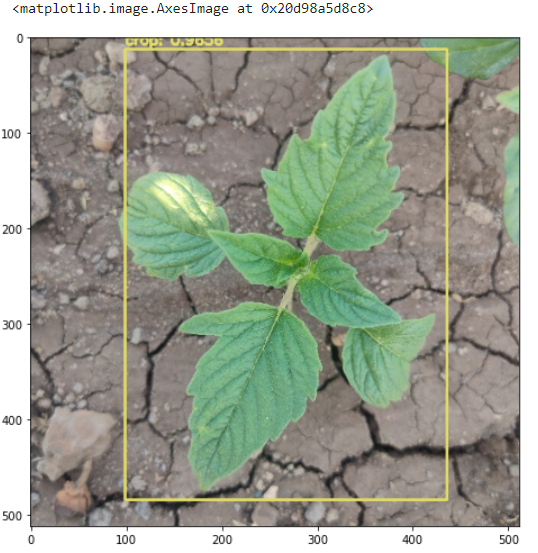

#### Testing

In [ ]:
test_samples =1000
batch_size_test=31

score= model.evaluate_generator(test_generator, steps = math.ceil(test_samples/batch_size_test))